In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [92]:
# pre processing, remove non existent outcome 
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df["month"] = df["month"].astype("category")
df["contact"] = df["contact"].astype("category")
df["day_of_week"] = df["day_of_week"].astype("category")
df = df[df["poutcome"] != "nonexistent"]
df['poutcome'] = df['poutcome'].map({'success': 1, 'failure': 0})
# 
X = df[["month", "day_of_week", "contact", "poutcome"]]

In [93]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
24013,38,blue-collar,single,unknown,no,yes,no,telephone,oct,tue,...,1,999,1,0,-0.1,93.798,-40.4,4.968,5195.8,no
24019,40,services,married,high.school,no,yes,no,telephone,oct,tue,...,1,999,1,0,-0.1,93.798,-40.4,4.968,5195.8,yes
24076,36,admin.,married,university.degree,no,yes,no,telephone,nov,wed,...,1,999,1,0,-0.1,93.200,-42.0,4.663,5195.8,no
24102,36,admin.,married,high.school,no,yes,no,telephone,nov,wed,...,1,999,1,0,-0.1,93.200,-42.0,4.286,5195.8,yes
24108,37,admin.,married,university.degree,no,yes,no,telephone,nov,wed,...,1,6,1,1,-0.1,93.200,-42.0,4.286,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,1,6,1,-1.1,94.767,-50.8,1.031,4963.6,yes
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,...,1,999,2,0,-1.1,94.767,-50.8,1.031,4963.6,no
41178,62,retired,married,university.degree,no,no,no,cellular,nov,thu,...,2,6,3,1,-1.1,94.767,-50.8,1.031,4963.6,yes
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,...,1,9,1,1,-1.1,94.767,-50.8,1.028,4963.6,no


In [94]:
class Campaign:
    def __init__(self, day_of_week="mon", month="jan", contact="telephone"):
        self.day_of_week = day_of_week
        self.month = month
        self.contact = contact 

    def optimize_campaign(self, df):
        ## Select the best day, contact method, and month 
        success_by_day = df.groupby("day_of_week",  observed=False)["poutcome"].mean().sort_values(ascending=False)
        success_by_contact = df.groupby("contact",  observed=False)["poutcome"].mean().sort_values(ascending=False)
        success_by_month = df.groupby("month", observed=False)["poutcome"].mean().sort_values(ascending=False)

        # Update 
        self.day_of_week = success_by_day.idxmax()
        self.contact = success_by_contact.idxmax()
        self.month = success_by_month.idxmax()

        print(f"Optimized Campaign: Day = {self.day_of_week}, Contact = {self.contact}, Month = {self.month}")


# Initialize Campaign
campaign = Campaign()

# Optimize Campaign Based on Past Data
campaign.optimize_campaign(df)

# Check Updated Campaign Parameters
print(f"New Best Campaign Strategy -> Day: {campaign.day_of_week}, Month: {campaign.month}, Contact: {campaign.contact}")


Optimized Campaign: Day = thu, Contact = telephone, Month = dec
New Best Campaign Strategy -> Day: thu, Month: dec, Contact: telephone


cleaning for feature importance analysis 
-> target variable: subscribed (0 or 1)

In [95]:
# Check dataset structure
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df = df[(df["poutcome"] != "nonexistent") & 
        (df["housing"] != "unknown") & 
        (df["default"] != "unknown") & 
        (df["loan"] != "unknown")]
df[["housing", "default", "loan"]] = df[["housing", "default", "loan"]].replace({"yes": 1, "no": 0})
df['poutcome'] = df['poutcome'].map({'success': 1, 'failure': 0})
print(df.info())

/var/folders/nf/fvzp8jgx7w5d98kpy9l2zh2r0000gn/T/ipykernel_19290/4008786040.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[["housing", "default", "loan"]] = df[["housing", "default", "loan"]].replace({"yes": 1, "no": 0})


<class 'pandas.core.frame.DataFrame'>
Index: 4924 entries, 24013 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4924 non-null   int64  
 1   job             4924 non-null   object 
 2   marital         4924 non-null   object 
 3   education       4924 non-null   object 
 4   default         4924 non-null   int64  
 5   housing         4924 non-null   int64  
 6   loan            4924 non-null   int64  
 7   contact         4924 non-null   object 
 8   month           4924 non-null   object 
 9   day_of_week     4924 non-null   object 
 10  duration        4924 non-null   int64  
 11  campaign        4924 non-null   int64  
 12  pdays           4924 non-null   int64  
 13  previous        4924 non-null   int64  
 14  poutcome        4924 non-null   int64  
 15  emp.var.rate    4924 non-null   float64
 16  cons.price.idx  4924 non-null   float64
 17  cons.conf.idx   4924 non-null   f

In [96]:
# features: job, age, marital, education, subscribed (to term deposit)
# label: poutcome(outcome of prev campaign) 

import pandas as pd
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df = df[['job', 'age', 'marital', 'education', 'subscribed', 'poutcome']]

# age groups 
def age_groups(df):
    bins = [0, 30, 40, 50, 60, float('inf')]  # Bins for age ranges
    labels = ['Below 30', '30-39', '40-49', '50-59', '60 and above']  # Labels for the bins
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
    df['age_group'] = pd.Categorical(df['age_group'], categories=labels, ordered=True)
    return df

clean_df = clean_df = df[(df['marital'] != 'unknown') & (df['education'] != 'unknown') & (df['job'] != 'unknown')]
clean_df['subscribed'] = clean_df['subscribed'].map({'yes': 1, 'no': 0})
cealn_df = age_groups(clean_df)



# clean_df.info()
# clean_df['job'].value_counts()
clean_df['education'].value_counts()

clean_df.head()


/var/folders/nf/fvzp8jgx7w5d98kpy9l2zh2r0000gn/T/ipykernel_19290/2223310703.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['subscribed'] = clean_df['subscribed'].map({'yes': 1, 'no': 0})
/var/folders/nf/fvzp8jgx7w5d98kpy9l2zh2r0000gn/T/ipykernel_19290/2223310703.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
/var/folders/nf/fvzp8jgx7w5d98kpy9l2zh2r0000gn/T/ipykernel_19290/2223310703.py:14: SettingWithCopyWarning:

,job,age,marital,education,subscribed,poutcome,age_group
0,housemaid,56,married,basic.4y,0,nonexistent,50-59
1,services,57,married,high.school,0,nonexistent,50-59
2,services,37,married,high.school,0,nonexistent,30-39
3,admin.,40,married,basic.6y,0,nonexistent,40-49
4,services,56,married,high.school,0,nonexistent,50-59


# economic status 
emp.var.rate: positive = more jobs created = more saving = more subscriptions 
cons.price.idx: inflation rate, high = more deposit  
cons.conf.idx: always negative, more negative (higher absolute val) = spend less = higher deposit   
euribor3m: short term interest, high interest = more subscription   
nr.employed: no. of employees, high = higher financial security = more deposits 
subcription to term deposit: yes or no 


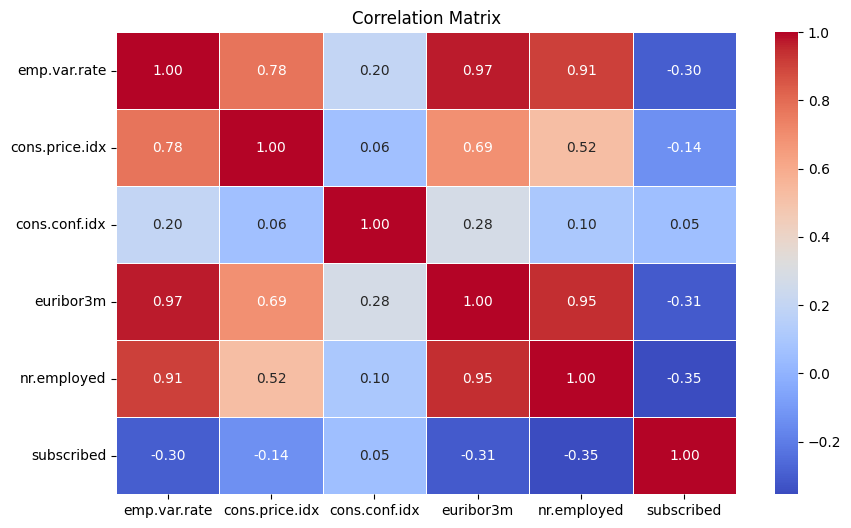

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
economics = data.copy()
economics = economics[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed']]

#cleaning
economics['subscribed'] = economics['subscribed'].map({'yes': 1, 'no': 0})

# plotting
correlation_matrix = economics.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# findings from correlation matrix 
euribor3m, emp.var.rate, nr.employed highly correlated to each other 

Feature Importance: [0.02326687 0.00666796 0.04144315 0.00318715 0.9254349 ]


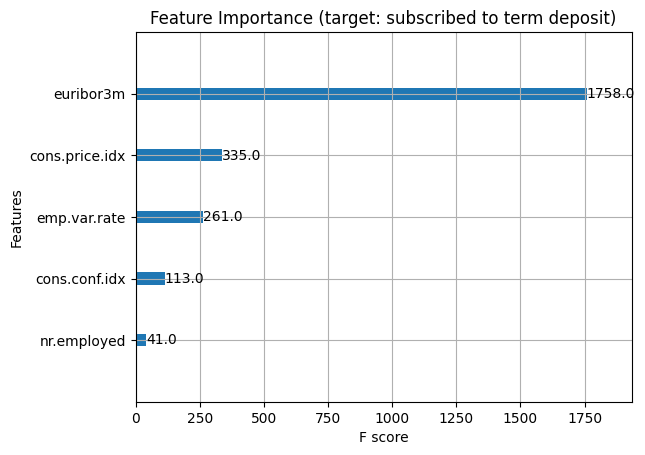

In [98]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare the data for training
X = economics[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
y = economics['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train an XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Get feature importances
importance = model.feature_importances_
print("Feature Importance:", importance)

xgb.plot_importance(model, importance_type='weight')
plt.title("Feature Importance (target: subscribed to term deposit)")
plt.show()

economics clusters

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df = df[['default', 'housing', 'loan',"emp.var.rate", "euribor3m", "nr.employed", "cons.price.idx", "cons.conf.idx", "subscribed"]]
econ_df = df[(df["housing"] != "unknown") & 
        (df["default"] != "unknown") & 
        (df["loan"] != "unknown")]


economic_factors = econ_df[["emp.var.rate", "euribor3m", "nr.employed", "cons.price.idx", "cons.conf.idx"]]
scaler = StandardScaler()
economic_factors_scaled = scaler.fit_transform(economic_factors)

kmeans = KMeans(n_clusters=3, random_state=42) 
econ_df['economic_cluster'] = kmeans.fit_predict(economic_factors_scaled)

silhouette_avg = silhouette_score(economic_factors_scaled, econ_df['economic_cluster'])
print(f"Silhouette Score: {silhouette_avg}")

cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster Centers (in original economic factors scale):\n", cluster_centers)

pd.crosstab(econ_df['economic_cluster'], econ_df['housing'], normalize='index')
# pd.crosstab(econ_df['economic_cluster'], econ_df['loan'], normalize='index')
# pd.crosstab(econ_df['economic_cluster'], econ_df['default'], normalize='index')
# pd.crosstab(econ_df['economic_cluster'], econ_df['subscribed'], normalize='index')




/var/folders/nf/fvzp8jgx7w5d98kpy9l2zh2r0000gn/T/ipykernel_19290/2014903648.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_df['economic_cluster'] = kmeans.fit_predict(economic_factors_scaled)


Silhouette Score: 0.6625066103168653
Cluster Centers (in original economic factors scale):
 [[ 1.08260935e+00  4.79837493e+00  5.21335003e+03  9.38119520e+01
  -3.95422309e+01]
 [-2.48292159e+00  7.91943878e-01  5.02115886e+03  9.30861423e+01
  -3.37542159e+01]
 [-1.86181278e+00  1.32359485e+00  5.09192110e+03  9.30137974e+01
  -4.62576152e+01]]


housing,no,yes
economic_cluster,,
0,0.480627,0.519373
1,0.445489,0.554511
2,0.412457,0.587543


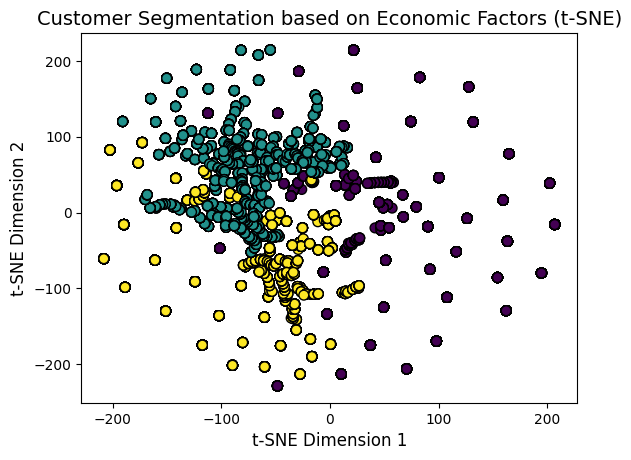

In [105]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
economic_factors_tsne = tsne.fit_transform(economic_factors_scaled)

# Plot t-SNE results
plt.scatter(economic_factors_tsne[:, 0], economic_factors_tsne[:, 1], c=econ_df['economic_cluster'], cmap='viridis', edgecolor='k', s=50)
plt.title("Customer Segmentation based on Economic Factors (t-SNE)", fontsize=14)
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.show()

In [107]:
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
